In [ ]:
!pip install umap-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.preprocessing import StandardScaler, LabelEncoder

import joblib

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [ ]:
working_directory = "/content/drive/MyDrive/Protacs_new_dataset/"
os.chdir(working_directory)
print("current working directory is: ", os.getcwd())

current working directory is:  /content/drive/MyDrive/Protacs_new_dataset


In [ ]:
data_dir = os.path.join(os.getcwd(), 'data')
src_dir = os.path.join(os.getcwd(), 'src')
fig_dir = os.path.join(data_dir, 'figures')
checkpoint_dir = os.path.join(os.getcwd(), 'checkpoints')
dirs_to_make = [
    data_dir,
    os.path.join(data_dir, 'raw'),
    os.path.join(data_dir, 'processed'),
    os.path.join(data_dir, 'train'),
    os.path.join(data_dir, 'val'),
    os.path.join(data_dir, 'test'),
    src_dir,
    fig_dir,
    checkpoint_dir,
]
for d in dirs_to_make:
    if not os.path.exists(d):
        os.makedirs(d)

In [ ]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# **LOADING TRAINING DATA** 😉

In [ ]:
!ls {train_dir}

cluster_train_data.csv		  stratified_train_data.csv
protbert_E3_train_embeddings.npy  stratified_train_e3_descriptors.csv
protbert_train_embeddings.npy	  stratified_train_fingerprints.csv
scaffold_train_data.csv		  stratified_train_protein_descriptors.csv
stratified_descriptors.csv


In [ ]:
df = pd.read_csv(os.path.join(train_dir, 'stratified_train_data.csv'))
df

,Uniprot,Smiles,E3 Ligase,Cell Type,POI Sequence,E3 Ligase Uniprot,E3 Ligase Sequence,Activity,scaffold
0,Q9Y243,C[C@@H]1C[C@@H](O)c2ncnc(N3CCN(C(=O)[C@H](CNCC...,CRBN,BT474,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C(CCNCC(C(=O)N1CCN(c2ncnc3c2CCC3)CC1)c1ccccc...
1,P40337,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,HeLa,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,True,O=C(COCCOCCOCCOCCOCCOCC(=O)NCC(=O)N1CCCC1C(=O)...
2,O43353,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,Human THP-1 monocytes,MNGEAICSALPTIPYHKLADLRYLSRGASGTVSSARHADWRVQVAV...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,True,O=C(COCCOCCOCCOCCOc1ccc2c(Nc3ccc4scnc4c3)ccnc2...
3,P10275,CC(=O)N[C@H](C(=O)N1C[C@@H](O)C[C@@H]1C(=O)N[C...,VHL,LNCaP,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(NC1CC(Oc2ccccc2)C1)c1ccc(C#CC2CCN(C(=O)CC(...
4,P03372,CCN(CCCCCCCC(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H]1...,VHL,MCF-7,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(CCCCCCCNCCOc1ccc(C(=O)c2c(-c3ccccc3)sc3ccc...
...,...,...,...,...,...,...,...,...,...
1117,P10275,N#Cc1ccc(O[C@H]2CC[C@H](NC(=O)c3ccc(NCCCCCCCCC...,CRBN,VCaP,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C1CCC(N2C(=O)c3ccc(NCCCCCCCCCCNc4ccc(C(=O)NC...
1118,P04035,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2cccc(OCCCCCc3cn(C...,CRBN,SRD15,MLSRLFRMHGLFVASHPWEVIVGTVTLTICMMSMNMFTGNNKICGW...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C1CCC(N2C(=O)c3ccc(NCCOCCOCCOCCOCCn4cc(CCCCC...
1119,Q05397,CN(c1nccnc1CNc1nc(Nc2ccc(NC(=O)c3cn(CCOCCNc4cc...,CRBN,PA1,MAAAYLDPNLNHTPNSSTKTHLGTGMERSPGAMERVLKVFHYFESN...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C1CCC(N2C(=O)c3cccc(NCCOCCn4cc(C(=O)Nc5ccc(N...
1120,P03372,CCN(CCCCCCCCCC(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H...,VHL,MCF-7,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(CCCCCCCCCNCCOc1ccc(C(=O)c2c(-c3ccccc3)sc3c...


In [ ]:
df['Uniprot'].value_counts()

Uniprot
P10275    119
O60885     72
Q06187     65
Q05397     62
P04035     56
         ... 
P40337      1
P62937      1
P52333      1
P31750      1
Q9NPI1      1
Name: count, Length: 95, dtype: int64

In [ ]:
# @title Encode the 'Activity' column
df['activity_encoded'] = df['Activity'].astype(int)
df.head()

,Uniprot,Smiles,E3 Ligase,Cell Type,POI Sequence,E3 Ligase Uniprot,E3 Ligase Sequence,Activity,scaffold,activity_encoded
0,Q9Y243,C[C@@H]1C[C@@H](O)c2ncnc(N3CCN(C(=O)[C@H](CNCC...,CRBN,BT474,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C(CCNCC(C(=O)N1CCN(c2ncnc3c2CCC3)CC1)c1ccccc...,1
1,P40337,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,HeLa,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,True,O=C(COCCOCCOCCOCCOCCOCC(=O)NCC(=O)N1CCCC1C(=O)...,1
2,O43353,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,Human THP-1 monocytes,MNGEAICSALPTIPYHKLADLRYLSRGASGTVSSARHADWRVQVAV...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,True,O=C(COCCOCCOCCOCCOc1ccc2c(Nc3ccc4scnc4c3)ccnc2...,1
3,P10275,CC(=O)N[C@H](C(=O)N1C[C@@H](O)C[C@@H]1C(=O)N[C...,VHL,LNCaP,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(NC1CC(Oc2ccccc2)C1)c1ccc(C#CC2CCN(C(=O)CC(...,0
4,P03372,CCN(CCCCCCCC(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H]1...,VHL,MCF-7,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(CCCCCCCNCCOc1ccc(C(=O)c2c(-c3ccccc3)sc3ccc...,0


## **Loading Descriptors and Fingerprints**
> * Descriptors and fingerprints are loaded and
> * then combined to form a net dataframe `norm_sm_desc_fps`, then,
> * it is **normalized using standard scaler**

In [ ]:
sm_desc = pd.read_csv(os.path.join(train_dir, 'stratified_descriptors.csv'))
sm_desc.shape

(1122, 39)

In [ ]:
sm_fps = pd.read_csv(os.path.join(train_dir, 'stratified_train_fingerprints.csv'))
sm_fps.shape

(1122, 2048)

In [ ]:
sm_desc_fps = pd.concat([sm_desc, sm_fps], axis=1)
sm_desc_fps.shape

(1122, 2087)

In [ ]:
sm_desc_fps = sm_desc_fps.drop(columns=['SPS'])
sm_desc_fps.shape

(1122, 2086)

In [ ]:
sm_desc_fps.head()

SMR_VSA9  fr_NH0  fr_piperzine  NumRotatableBonds  SlogP_VSA3  \
0   0.000000       5             1                 19   19.178149   
1  20.881197       4             0                 31   70.277914   
2  16.190111       4             0                 24   49.713073   
3  23.659602       3             0                 12   19.178149   
4  27.689134       2             0                 21   14.383612   

   BCUT2D_MWHI  EState_VSA10  PEOE_VSA14  fr_Al_OH_noTert  NumHDonors  \
0    35.495694     33.873750         0.0                1           5   
1    32.134669     38.980278         0.0                2           6   
2    32.228166     27.907936         0.0                1           4   
3    35.495694     34.341105         0.0                1           4   
4    35.495694     34.497731         0.0                1           5   

   SlogP_VSA8     Kappa2  NumSaturatedRings  BCUT2D_CHGLO     Kappa3  \
0    0.000000  20.613056                  2     -2.376319  10.247743   
1   20.881197  31.746324                  2     -2.349304  19.941447   
2   31.560144  24.588272                  1     -2.349268  14.354223   
3    0.000000  19.876519                  3     -2.626166  10.715243   
4   20.526743  22.821995                  1     -2.352408  13.115966   

   PEOE_VSA3       qed  PEOE_VSA1  BCUT2D_MRHI  fr_Al_OH   SMR_VSA1  \
0   9.967957  0.085534  30.856713     6.301800         1  33.873750   
1   9.967957  0.039318  69.701206     7.132751         2  67.401456   
2  18.385754  0.045475  49.641118     7.924719         1  51.592251   
3   0.000000  0.165226  35.593576     6.314119         1  33.816076   
4   0.000000  0.035584  40.489842     7.224499         1  39.234594   

   NumSaturatedHeterocycles  BalabanJ  VSA_EState3  NumAliphaticRings  \
0                         2  0.766404    22.912570                  4   
1                         2  0.763423    32.488933                  2   
2                         1  0.779207    20.290832                  1   
3                         2  1.014647    29.019853                  3   
4                         1  0.902618    37.777908                  1   

   EState_VSA2  NumAliphaticHeterocycles  SlogP_VSA10   SMR_VSA6  \
0    41.700812                         3    11.505249  62.574750   
1   103.690084                         2     0.000000  92.372096   
2    95.524447                         1    11.374773  71.323483   
3    61.089558                         2     0.000000  19.634269   
4    60.432048                         1     0.000000  32.785908   

   fr_sulfonamd  SlogP_VSA7  EState_VSA8  fr_piperdine  NHOHCount  fr_aniline  \
0             0    5.022633    43.058758             1          5           2   
1             0    0.000000    31.235111             0          6           0   
2             0    0.000000    30.902301             0          4           2   
3             0    5.022633    61.555405             1          4           0   
4             0    5.022633    22.457224             0          5           0   

   fr_COO2  fr_Al_COO  fr_COO  FP_0  FP_1  FP_2  FP_3  FP_4  FP_5  FP_6  FP_7  \
0        0          0       0     0     1     0     0     0     0     0     0   
1        0          0       0     0     1     0     0     0     0     0     0   
2        0          0       0     0     1     0     0     0     0     0     0   
3        0          0       0     0     1     0     0     0     0     0     0   
4        0          0       0     0     1     0     0     0     0     0     0   

   FP_8  FP_9  FP_10  FP_11  FP_12  FP_13  FP_14  FP_15  FP_16  FP_17  FP_18  \
0     0     0      0      0      0      0      0      0      1      0      0   
1     0     0      0      0      0      1      0      0      0      0      0   
2     1     0      0      0      0      1      0      0      0      0      1   
3     0     0      0      0      0      0      0      0      0      1      0   
4     0     1      0      0      0      1      0      0      0      

In [ ]:
# @title Normalizing Data -> Standard scaler

y = df['activity_encoded']

scaler = StandardScaler()

norm_sm_desc_fps = scaler.fit_transform(sm_desc_fps)

In [ ]:
joblib.dump(scaler, 'strat_scaler.pkl')

['strat_scaler.pkl']

In [ ]:
y.values

array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
norm_sm_desc_fps

array([[-1.56069309, -0.16582131,  1.13855304, ..., -0.32802619,
        -0.31793001,  0.        ],
       [ 0.47120949, -0.62748759, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ],
       [ 0.01473033, -0.62748759, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ],
       ...,
       [-1.56069309,  1.68084382, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ],
       [ 2.14962588, -1.08915388, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ],
       [-1.00122097, -0.62748759, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ]])

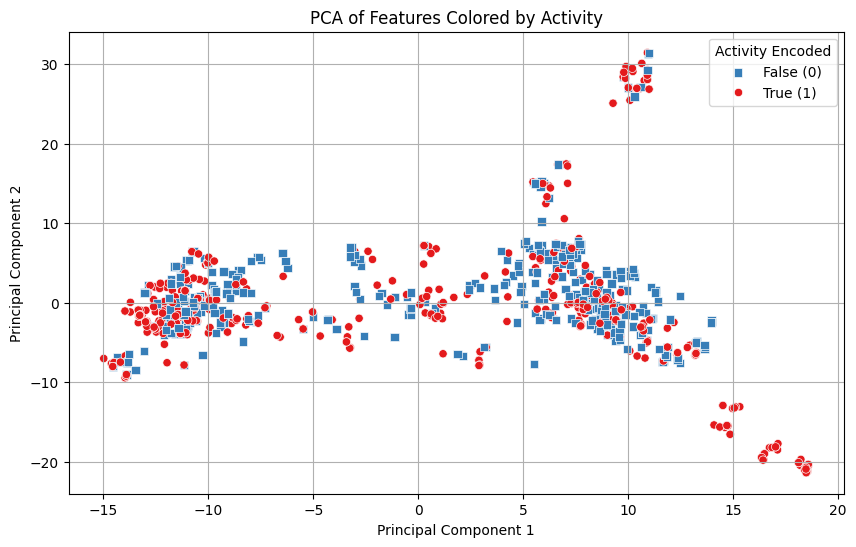

In [ ]:
# @title Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(norm_sm_desc_fps)

pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['activity_encoded'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='activity_encoded', palette='Set1', style='activity_encoded', markers=['o', 's'])
plt.title('PCA of Features Colored by Activity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity Encoded', loc='best', labels=['False (0)', 'True (1)'])
plt.grid()
plt.show()

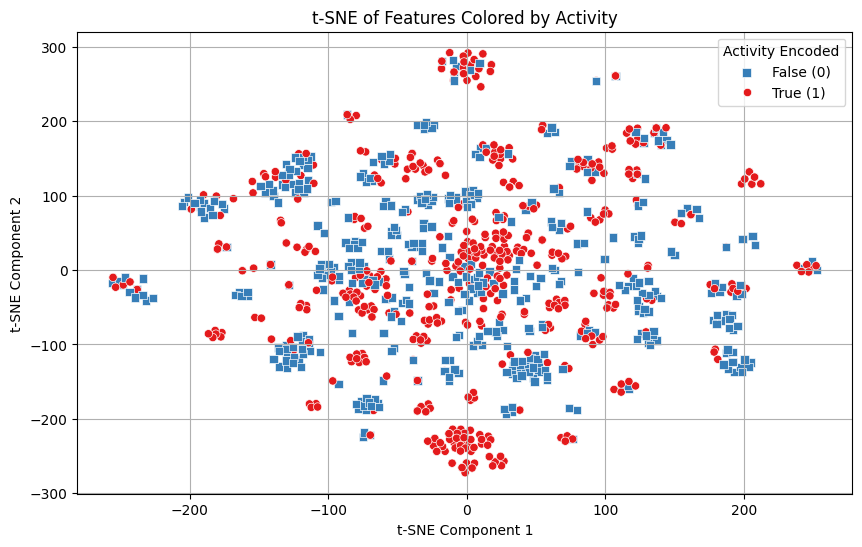

In [ ]:
# @title Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity = 30, n_iter = 3000)
X_tsne = tsne.fit_transform(norm_sm_desc_fps)

tsne_df = pd.DataFrame(data=X_tsne, columns=['t-SNE1', 't-SNE2'])
tsne_df['activity_encoded'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='t-SNE1', y='t-SNE2', hue='activity_encoded', palette='Set1', style='activity_encoded', markers=['o', 's'])
plt.title('t-SNE of Features Colored by Activity')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Activity Encoded', loc='best', labels=['False (0)', 'True (1)'])
plt.grid()
plt.show()

In [ ]:
# @title 3D t-SNE
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(norm_sm_desc_fps)

tsne_df = pd.DataFrame(data=X_tsne, columns=['t-SNE1', 't-SNE2', 't-SNE3'])
tsne_df['activity_encoded'] = y.values

import plotly.express as px
fig = px.scatter_3d(tsne_df, x='t-SNE1', y='t-SNE2', z='t-SNE3',
                    color='activity_encoded',
                    labels={'activity_encoded': 'Activity'},
                    title='3D t-SNE of Features Colored by Activity',
                    color_continuous_scale=px.colors.sequential.Viridis)

fig.update_layout(
    scene=dict(
        xaxis_title='t-SNE1',
        yaxis_title='t-SNE2',
        zaxis_title='t-SNE3',
    ),
    width=1000,
    height=800,
)

fig.show()

In [ ]:
print("Shape of smile embedding: ", norm_sm_desc_fps.shape)

Shape of smile embedding:  (1122, 2086)


In [ ]:
X_smiles = norm_sm_desc_fps

## **Loading POI Embeddings 😊**

In [ ]:
!ls {train_dir}

cluster_train_data.csv		  stratified_train_data.csv
protbert_E3_train_embeddings.npy  stratified_train_e3_descriptors.csv
protbert_train_embeddings.npy	  stratified_train_fingerprints.csv
scaffold_train_data.csv		  stratified_train_protein_descriptors.csv
stratified_descriptors.csv


In [ ]:
poi_embeddings = np.load(os.path.join(train_dir, 'protbert_train_embeddings.npy'))

print("Shape of the POI embeddings:", poi_embeddings.shape)
print("Embeddings data:\n", poi_embeddings)

Shape of the POI embeddings: (1122, 1, 1024)
Embeddings data:
 [[[ 0.06918799  0.00155882 -0.01264032 ... -0.01606458 -0.01030827
    0.04386651]]

 [[ 0.15248436  0.02510947  0.09244031 ... -0.06867211 -0.03839676
    0.04213306]]

 [[ 0.1039056   0.09255033  0.10229391 ... -0.11319582 -0.02461505
   -0.00940223]]

 ...

 [[ 0.11961086  0.05782434  0.08992973 ... -0.1049777  -0.03194818
   -0.0060858 ]]

 [[ 0.11895037  0.05142664  0.06081541 ... -0.11223464 -0.02315826
   -0.00506803]]

 [[ 0.13972294  0.05250182  0.06997536 ... -0.11280623 -0.0153316
   -0.00352748]]]


In [ ]:
type(poi_embeddings)

numpy.ndarray

In [ ]:
X_poi = poi_embeddings

### **Visualizing POI Embeddings**

In [ ]:
# Embeddings are in shape (1122, 1, 1024)
reshaped_poi_embeddings = poi_embeddings.squeeze()  # Remove singleton dimensions
print("Shape of reshaped POI embeddings:", reshaped_poi_embeddings.shape)

Shape of reshaped POI embeddings: (1122, 1024)


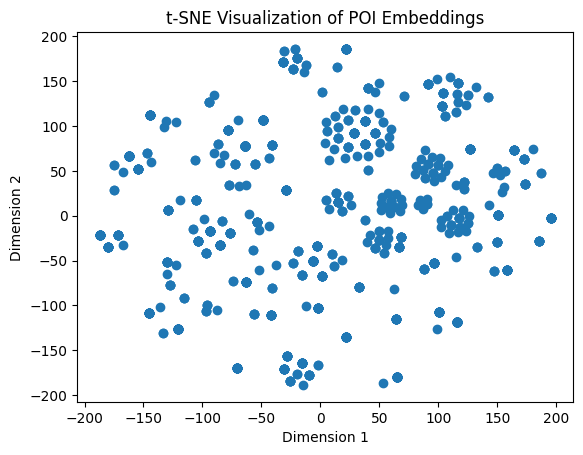

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(reshaped_poi_embeddings)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization of POI Embeddings')
plt.show()


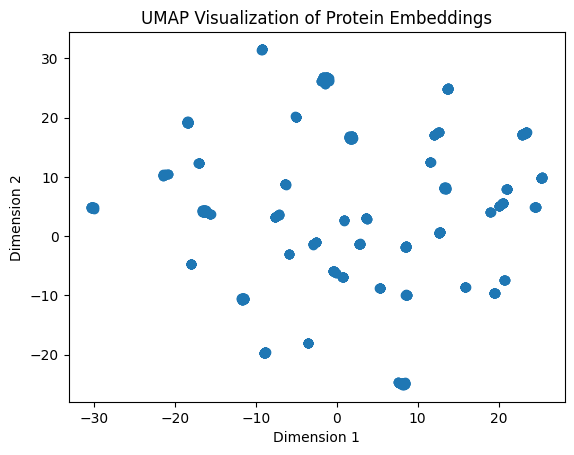

In [ ]:
import umap
import matplotlib.pyplot as plt

umap_model = umap.UMAP(n_components=2, random_state=0)
embeddings_2d = umap_model.fit_transform(reshaped_poi_embeddings)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('UMAP Visualization of Protein Embeddings')
plt.show()


In [ ]:
protein_names = df['Uniprot'].values

In [ ]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder

umap_model = umap.UMAP(n_components=2, random_state=0)
reduced_embeddings = umap_model.fit_transform(reshaped_poi_embeddings)

vis_df = pd.DataFrame(reduced_embeddings, columns=['UMAP1', 'UMAP2'])
vis_df['protein_name'] = protein_names

label_encoder = LabelEncoder()
vis_df['protein_name_encoded'] = label_encoder.fit_transform(vis_df['protein_name'])

fig = px.scatter(
    vis_df,
    x='UMAP1',
    y='UMAP2',
    color='protein_name',
    title='Protein Sequence Embeddings Visualization with UMAP',
    labels={'UMAP1': 'UMAP Component 1', 'UMAP2': 'UMAP Component 2'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.show()

## **Loading E3 ligase embedding 👻**

In [ ]:
E3_embeddings = np.load(os.path.join(train_dir, 'protbert_E3_train_embeddings.npy'))

print("Shape of the E3 embeddings:", E3_embeddings.shape)
print("Embeddings data:\n", E3_embeddings)

In [ ]:
X_e3 = E3_embeddings

### **Visualizing E3 Ligase Embeddings**

In [ ]:
df.columns

Index(['Uniprot', 'Smiles', 'E3 Ligase', 'Cell Type', 'POI Sequence',
       'E3 Ligase Uniprot', 'E3 Ligase Sequence', 'Activity', 'scaffold',
       'activity_encoded'],
      dtype='object')

In [ ]:
protein_names = df['E3 Ligase'].values

In [ ]:
reshaped_E3_embeddings = E3_embeddings.squeeze()
print("Shape of reshaped E3 embeddings:", reshaped_E3_embeddings.shape)

In [ ]:
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(reshaped_E3_embeddings)

vis_df = pd.DataFrame(reduced_embeddings, columns=['UMAP1', 'UMAP2'])
vis_df['protein_name'] = protein_names

label_encoder = LabelEncoder()
vis_df['protein_name_encoded'] = label_encoder.fit_transform(vis_df['protein_name'])

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='protein_name', palette='tab10', data=vis_df, legend='full')
plt.title('Protein Sequence Embeddings Visualization with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
print("shape of Label column:", y.shape)

shape of Label column: (1122,)


In [ ]:
print("Value counts of label column are: ",y.value_counts())

Value counts of label column are:  activity_encoded
1    564
0    558
Name: count, dtype: int64


# **LOADING VALIDATION DATA 😊**

In [ ]:
# val_dir = os.path.join(data_dir, 'val')

In [ ]:
!ls {val_dir}

cluster_val_data.csv		scaffold_val_data.csv	    stratified_val_e3_descriptors.csv
protbert_E3_val_embeddings.npy	stratified_descriptors.csv  stratified_val_fingerprints.csv
protbert_val_embeddings.npy	stratified_val_data.csv     stratified_val_protein_descriptors.csv


In [ ]:
df_val = pd.read_csv(os.path.join(val_dir, 'stratified_val_data.csv'))

In [ ]:
df_val

,Uniprot,Smiles,E3 Ligase,Cell Type,POI Sequence,E3 Ligase Uniprot,E3 Ligase Sequence,Activity,scaffold
0,Q9UHD2,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,Panc02.13,MQSTSNHLWLLSDILGQGATANVFRGRHKKTGDLFAIKVFNNISFL...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(COCCCOCCCOc1ccc(Nc2nccc(NCCCNC(=O)C3CCC3)n...
1,Q9UM73,CCc1cc2c(cc1N1CCC(N3CCN(CCCC#Cc4cccc5c4CN(C4CC...,CRBN,SR,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C1CCC(N2Cc3c(C#CCCCN4CCN(C5CCN(c6ccc7c(c6)Cc...
2,P10275,CN(c1ccc(C#N)c(Cl)c1)[C@H]1CC[C@H](NC(=O)c2ccc...,CRBN,VCaP,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C1CCC(N2C(=O)c3ccc(N4CCN(C5CCN(c6ccc(C(=O)NC...
3,P51532,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,A549,MSTPDPPLGGTPRPGPSPGPGPSPGAMLGPSPGPSPGSAHSMMGPS...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,True,O=C(NCC(=O)N1CCCC1C(=O)NCc1ccc(-c2cncs2)cc1OCC...
4,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,RS4;11,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,True,O=C(CCCCCCCCC(=O)NCC1CCC(c2ccccc2)=C(CN2CCN(c3...
...,...,...,...,...,...,...,...,...,...
316,P04035,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2cccc(OCCCc3cn(CCO...,CRBN,SRD15,MLSRLFRMHGLFVASHPWEVIVGTVTLTICMMSMNMFTGNNKICGW...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCOCCOCCn4cc(CCCO...
317,P10275,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,LNCaP,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(COCCCOCCN1CCC(c2ccc(N3CC(=O)N(c4ccccc4)C3=...
318,P33981,CCC(=O)N[C@H]1CC[C@@H](n2c(=O)cc(C)c3cnc(Nc4cc...,CRBN,HCT-116,MESEDLSGRELTIDSIMNKVRDIKNKFKNEDLTDELSLNKISADTT...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C1CCC(N2Cc3cc(C#CCCCC(=O)N4CCN(c5ccc(Nc6ncc7...
319,Q13547,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,HCT116,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(COCCCCCCCCC(=O)Nc1ccc(C(=O)Nc2ccccc2)cc1)N...


In [ ]:
# @title Encode the 'activity' column

df_val['activity_encoded'] = df_val['Activity'].astype(int)
df_val.head()

,Uniprot,Smiles,E3 Ligase,Cell Type,POI Sequence,E3 Ligase Uniprot,E3 Ligase Sequence,Activity,scaffold,activity_encoded
0,Q9UHD2,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,Panc02.13,MQSTSNHLWLLSDILGQGATANVFRGRHKKTGDLFAIKVFNNISFL...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(COCCCOCCCOc1ccc(Nc2nccc(NCCCNC(=O)C3CCC3)n...,0
1,Q9UM73,CCc1cc2c(cc1N1CCC(N3CCN(CCCC#Cc4cccc5c4CN(C4CC...,CRBN,SR,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C1CCC(N2Cc3c(C#CCCCN4CCN(C5CCN(c6ccc7c(c6)Cc...,0
2,P10275,CN(c1ccc(C#N)c(Cl)c1)[C@H]1CC[C@H](NC(=O)c2ccc...,CRBN,VCaP,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C1CCC(N2C(=O)c3ccc(N4CCN(C5CCN(c6ccc(C(=O)NC...,1
3,P51532,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,A549,MSTPDPPLGGTPRPGPSPGPGPSPGAMLGPSPGPSPGSAHSMMGPS...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,True,O=C(NCC(=O)N1CCCC1C(=O)NCc1ccc(-c2cncs2)cc1OCC...,1
4,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,RS4;11,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,True,O=C(CCCCCCCCC(=O)NCC1CCC(c2ccccc2)=C(CN2CCN(c3...,1


## **Loading Descriptors and Fingerprints**

In [ ]:
val_sm_desc = pd.read_csv(os.path.join(val_dir, 'stratified_descriptors.csv'))
val_sm_desc.shape

(321, 39)

In [ ]:
val_sm_fps = pd.read_csv(os.path.join(val_dir, 'stratified_val_fingerprints.csv'))
val_sm_fps.shape

(321, 2048)

In [ ]:
val_sm_desc_fps = pd.concat([val_sm_desc, val_sm_fps], axis=1)
val_sm_desc_fps.shape

(321, 2087)

In [ ]:
val_sm_desc_fps = val_sm_desc_fps.drop(columns=['SPS'])
val_sm_desc_fps.shape

(321, 2086)

In [ ]:
print("Shape of Validation smile embedding: ",val_sm_desc_fps.shape)

Shape of Validation smile embedding:  (321, 2086)


In [ ]:
# @title Normalizing
loaded_scaler = joblib.load('/content/drive/MyDrive/Protacs_new_dataset/Pickles/strat_scaler.pkl')

val_scaled = loaded_scaler.transform(val_sm_desc_fps)

In [ ]:
val_scaled

array([[ 0.01473033, -0.16582131, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ],
       [ 0.18209768, -0.16582131,  1.13855304, ..., -0.32802619,
        -0.31793001,  0.        ],
       [-0.97011075,  0.29584497,  1.13855304, ..., -0.32802619,
        -0.31793001,  0.        ],
       ...,
       [ 0.15098746,  0.29584497,  1.13855304, ..., -0.32802619,
         3.14534639,  0.        ],
       [-0.5447418 , -1.55082016, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ],
       [-0.5447418 , -0.62748759,  1.13855304, ...,  3.04853702,
        -0.31793001,  0.        ]])

In [ ]:
val_y = df_val['activity_encoded']

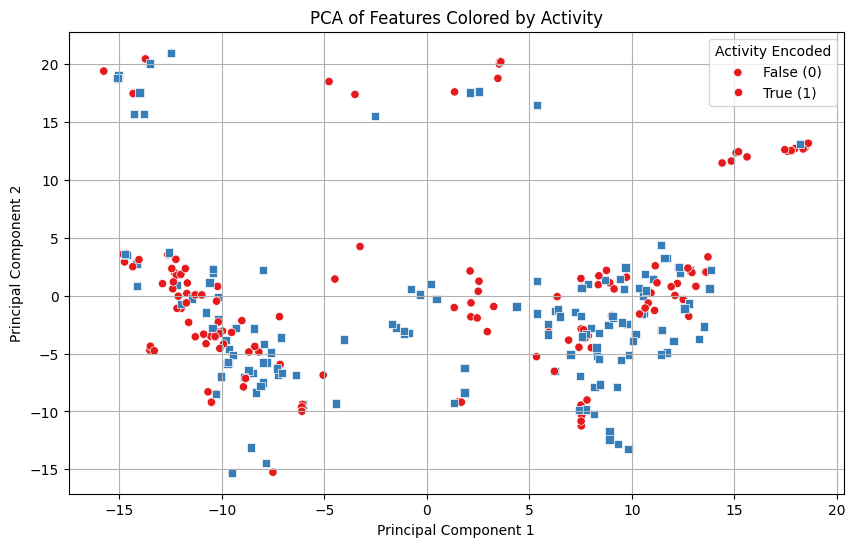

In [ ]:
# @title Apply PCA
pca = PCA(n_components=2)
val_pca = pca.fit_transform(val_scaled)

val_pca_df = pd.DataFrame(data=val_pca, columns=['PCA1', 'PCA2'])
val_pca_df['activity_encoded'] = val_y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=val_pca_df, x='PCA1', y='PCA2', hue='activity_encoded', palette='Set1', style='activity_encoded', markers=['o', 's'])
plt.title('PCA of Features Colored by Activity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity Encoded', loc='best', labels=['False (0)', 'True (1)'])
plt.grid()
plt.show()

In [ ]:
# @title Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
val_tsne = tsne.fit_transform(val_scaled)

val_tsne_df = pd.DataFrame(data=val_tsne, columns=['t-SNE1', 't-SNE2'])
val_tsne_df['activity_encoded'] = val_y.values


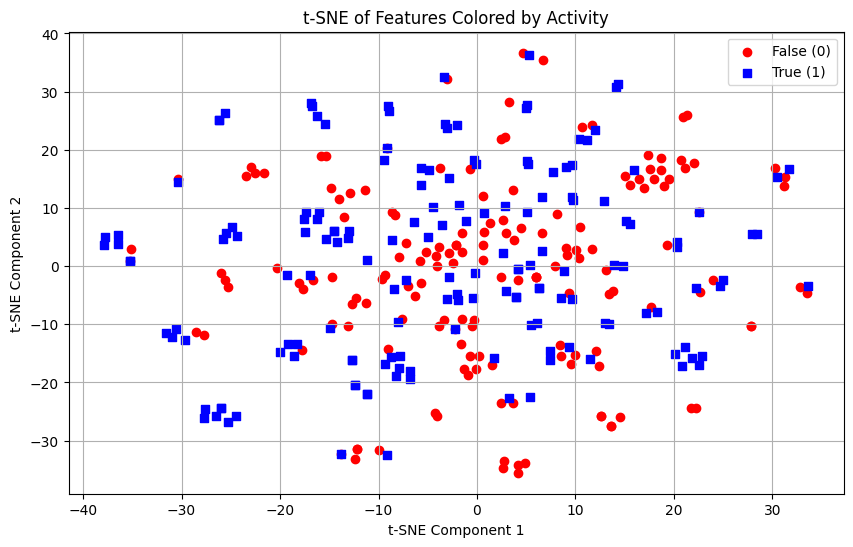

In [ ]:
plt.figure(figsize=(10, 6))

for activity in val_tsne_df['activity_encoded'].unique():
    subset = val_tsne_df[val_tsne_df['activity_encoded'] == activity]
    if activity == 0:
        plt.scatter(subset['t-SNE1'], subset['t-SNE2'],   # Changed column names to 't-SNE1' and 't-SNE2'
                    color='red', marker='o', label='False (0)')
    else:
        plt.scatter(subset['t-SNE1'], subset['t-SNE2'],   # Changed column names to 't-SNE1' and 't-SNE2'
                    color='blue', marker='s', label='True (1)')

plt.title('t-SNE of Features Colored by Activity')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid()
plt.show()

## **Loading Validation POI Embeddings**

In [ ]:
val_poi_embeddings = np.load(os.path.join(val_dir, 'protbert_val_embeddings.npy'))

print("Shape of the Validation POI embeddings:", val_poi_embeddings.shape)
print("Embeddings data:\n", val_poi_embeddings)

Shape of the Validation POI embeddings: (321, 1, 1024)
Embeddings data:
 [[[ 0.11792369  0.05213594  0.06596293 ... -0.09574159 -0.01231348
    0.01201408]]

 [[ 0.10675804  0.12840816  0.08193635 ... -0.05629908  0.02347085
   -0.05023538]]

 [[ 0.13386932  0.05353366  0.06886507 ... -0.09261743 -0.01357403
   -0.00138775]]

 ...

 [[ 0.13438049  0.03429785  0.08953726 ... -0.07967326 -0.02633449
    0.01365529]]

 [[ 0.11312814  0.04918689  0.12241347 ... -0.06255518 -0.03805839
    0.00376084]]

 [[ 0.10449585  0.05101578  0.12678877 ... -0.05913703 -0.03569289
   -0.00542179]]]


## **Loading Validation E3 Embeddings**

In [ ]:
val_E3_embeddings = np.load(os.path.join(val_dir, 'protbert_E3_val_embeddings.npy'))

print("Shape of the Validation E3 embeddings:", val_E3_embeddings.shape)
print("Embeddings data:\n", val_E3_embeddings)

Shape of the Validation E3 embeddings: (321, 1, 1024)
Embeddings data:
 [[[ 0.15248436  0.02510947  0.09244031 ... -0.06867211 -0.03839676
    0.04213306]]

 [[-0.04554553  0.03944096  0.06054781 ... -0.02079358 -0.0029738
    0.02482352]]

 [[-0.04554553  0.03944096  0.06054781 ... -0.02079358 -0.0029738
    0.02482352]]

 ...

 [[-0.04554553  0.03944096  0.06054781 ... -0.02079358 -0.0029738
    0.02482352]]

 [[ 0.15248436  0.02510947  0.09244031 ... -0.06867211 -0.03839676
    0.04213306]]

 [[ 0.15248436  0.02510947  0.09244031 ... -0.06867211 -0.03839676
    0.04213306]]]


# **🔴🔴LOADING TEST DATA🟢🟢**

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Protacs_new_dataset/data/test/stratified_test_data.csv")
test_df

,Uniprot,Smiles,E3 Ligase,Cell Type,POI Sequence,E3 Ligase Uniprot,E3 Ligase Sequence,Activity,scaffold
0,Q06187,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2C...,CRBN,THP-1,MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDFER...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCOCCOCC(=O)N4CCC...
1,Q9UHD2,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,Panc02.13,MQSTSNHLWLLSDILGQGATANVFRGRHKKTGDLFAIKVFNNISFL...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(COCCOCCOc1ccc(Nc2nccc(NCCCNC(=O)C3CCC3)n2)...
2,O60885,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)NCCC...,CRBN,MV4-11,MSAESGPGTRLRNLPVMGDGLETSQMSTTQAQAQPQPANAASTNPP...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C(COc1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O)NCCC...
3,P10275,CN(c1ccc(C#N)c(Cl)c1)[C@H]1CC[C@H](NC(=O)c2ccc...,CRBN,LNCaP,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C1CCC(N2C(=O)c3ccc(N4CCN(CC5CN(c6ccc(C(=O)NC...
4,P00520,Cc1ccc(NC(=O)c2ccc(CN3CCN(C(=O)CCCc4cn(CCNc5cc...,CRBN,K562,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C1CCC(N2C(=O)c3cccc(NCCn4cc(CCCC(=O)N5CCN(Cc...
...,...,...,...,...,...,...,...,...,...
156,P35613,COC(=O)C1=CC[C@@]23CC[C@H]([C@@](C)(/C=C/C=C(\...,CRBN,Sk-Mel-28,MAAALFVLLGFALLGTHGASGAAGFVQAPLSQQRWVGGSVELHCEA...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C1CCC(N2C(=O)c3cccc(OCCCOC(=O)C=CC=CC4OC(=O)...
157,P03372,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,MCF-7,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(CCCCCCCN(CCOc1ccc(C(=O)c2c(-c3ccccc3)sc3cc...
158,O43924,Cc1ccc(-n2nc3c(=O)n(CCCC(=O)NCCCCCCCCNc4cccc5c...,CRBN,SW480,MSAKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHE...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C(CCCn1ncc2cn(-c3ccccc3)nc2c1=O)NCCCCCCCCNc1...
159,A8DG50,CCC[C@H](NC(=O)[C@@H]1[C@H]2CCC[C@H]2CN1C(=O)[...,CRBN,Huh7.5,MSTNPKPQRKTKRNTNRRPQDVKFPGGGQIVGGVYLLPRRGPRLGV...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCNC(=O)c4cnc(C(=...


In [ ]:
test_df['activity_encoded'] = test_df['Activity'].astype(int)
test_df.head()

,Uniprot,Smiles,E3 Ligase,Cell Type,POI Sequence,E3 Ligase Uniprot,E3 Ligase Sequence,Activity,scaffold,activity_encoded
0,Q06187,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2C...,CRBN,THP-1,MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDFER...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCOCCOCC(=O)N4CCC...,0
1,Q9UHD2,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,Panc02.13,MQSTSNHLWLLSDILGQGATANVFRGRHKKTGDLFAIKVFNNISFL...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,False,O=C(COCCOCCOc1ccc(Nc2nccc(NCCCNC(=O)C3CCC3)n2)...,0
2,O60885,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)NCCC...,CRBN,MV4-11,MSAESGPGTRLRNLPVMGDGLETSQMSTTQAQAQPQPANAASTNPP...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C(COc1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O)NCCC...,1
3,P10275,CN(c1ccc(C#N)c(Cl)c1)[C@H]1CC[C@H](NC(=O)c2ccc...,CRBN,LNCaP,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,True,O=C1CCC(N2C(=O)c3ccc(N4CCN(CC5CN(c6ccc(C(=O)NC...,1
4,P00520,Cc1ccc(NC(=O)c2ccc(CN3CCN(C(=O)CCCc4cn(CCNc5cc...,CRBN,K562,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,False,O=C1CCC(N2C(=O)c3cccc(NCCn4cc(CCCC(=O)N5CCN(Cc...,0


In [ ]:
y_test = test_df['activity_encoded']

In [ ]:
y_test = np.array(y_test)
y_test.shape

(161,)

In [ ]:
test_desc = pd.read_csv("/content/drive/MyDrive/Protacs_new_dataset/data/test/stratified_descriptors.csv")
test_desc.shape

(161, 39)

In [ ]:
test_fing = pd.read_csv("/content/drive/MyDrive/Protacs_new_dataset/data/test/stratified_test_fingerprints.csv")
test_fing.shape

(161, 2048)

In [ ]:
# concatenate test_desc and test_fing
test_sm_fin = pd.concat([test_desc, test_fing], axis=1)
test_sm_fin.shape

(161, 2087)

In [ ]:
test_sm_fin = test_sm_fin.drop(columns=['SPS'])

In [ ]:
test_sm_fin.shape

(161, 2086)

In [ ]:
ls

 1_Preprocessing_file.ipynb         6.3_GNNs.ipynb             model.png
 2_Final_df_no_unknown.ipynb        checkpoints/               Models/
 3_Train_test_split.ipynb           CV_based/                  Pickles/
 4_Embeddings.ipynb                 data/                      protac.csv
 5_Trial_Alhphafold.ipynb           Fingerprints.ipynb         src/
 6.1_Model_building.ipynb           model_architecture_1.png   stratified_train_data.csv
'6.2_CrossV_model building.ipynb'   model_architecture.png     strat_scaler.pkl


In [ ]:
# @title Test Smile dataset ready

loaded_scaler = joblib.load('Pickles/strat_scaler.pkl')

scaled_new_data = loaded_scaler.transform(test_sm_fin)
scaled_new_data

array([[ 0.65368157, -0.62748759, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ],
       [ 0.01473033, -0.16582131, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ],
       [-0.51457687, -0.16582131, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ],
       ...,
       [-1.00726626, -0.16582131, -0.69423966, ...,  3.04853702,
        -0.31793001,  0.        ],
       [-1.56069309, -0.62748759, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ],
       [ 0.74156981, -0.16582131, -0.69423966, ..., -0.32802619,
        -0.31793001,  0.        ]])

In [ ]:
# @title Test POI SEquence embedding

test_poi = np.load('/content/drive/MyDrive/Protacs_new_dataset/data/test/protbert_test_embeddings.npy')

print("Shape of loaded data:", test_poi.shape)
print("Contents of loaded data:\n", test_poi)

Shape of loaded data: (161, 1, 1024)
Contents of loaded data:
 [[[ 0.13412037  0.07427318  0.08591191 ... -0.10232249 -0.01976052
   -0.00503152]]

 [[ 0.11792369  0.05213594  0.06596293 ... -0.09574159 -0.01231348
    0.01201408]]

 [[ 0.13604625  0.02717702  0.08883504 ... -0.07814994 -0.02493382
    0.01673504]]

 ...

 [[ 0.00089279  0.09094822  0.11009035 ... -0.10542949 -0.03951297
   -0.03550949]]

 [[ 0.13015376  0.05166768  0.10018101 ... -0.05178107 -0.0638878
    0.0063006 ]]

 [[ 0.13386932  0.05353366  0.06886507 ... -0.09261743 -0.01357403
   -0.00138775]]]


In [ ]:
# @title Test E3 LIGASE embeddings

test_e3 = np.load("/content/drive/MyDrive/Protacs_new_dataset/data/test/protbert_E3_test_embeddings.npy")

print("Shape of loaded data:", test_e3.shape)
print("Contents of loaded data:\n", test_e3)

Shape of loaded data: (161, 1, 1024)
Contents of loaded data:
 [[[-0.04554553  0.03944096  0.06054781 ... -0.02079358 -0.0029738
    0.02482352]]

 [[ 0.15248436  0.02510947  0.09244031 ... -0.06867211 -0.03839676
    0.04213306]]

 [[-0.04554553  0.03944096  0.06054781 ... -0.02079358 -0.0029738
    0.02482352]]

 ...

 [[-0.04554553  0.03944096  0.06054781 ... -0.02079358 -0.0029738
    0.02482352]]

 [[-0.04554553  0.03944096  0.06054781 ... -0.02079358 -0.0029738
    0.02482352]]

 [[ 0.15248436  0.02510947  0.09244031 ... -0.06867211 -0.03839676
    0.04213306]]]


# **😂🤷‍♂️Model building**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Add, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
X_train_smiles = norm_sm_desc_fps
X_train_poi = poi_embeddings
X_train_e3 = E3_embeddings
y_train = y

X_val_smiles = val_scaled
X_val_poi = val_poi_embeddings
X_val_e3 = val_E3_embeddings
y_val = val_y

In [ ]:
X_train_smiles.shape, X_train_poi.shape, X_train_e3.shape, y_train.shape

((1122, 2086), (1122, 1, 1024), (1122, 1, 1024), (1122,))

In [ ]:
# @title MODEL-1

# Define input layers
smile_input = Input(shape=(2086,), name='smile_input')
poi_input = Input(shape=(1, 1024), name='poi_input')
e3_input = Input(shape=(1, 1024), name='e3_input')

# CNN for SMILES embeddings
smile_x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(tf.expand_dims(smile_input, axis=-1))
smile_x = MaxPooling1D(pool_size=2)(smile_x)
smile_x = Flatten()(smile_x)

# LSTM for POI embeddings
poi_x = LSTM(1024, return_sequences=True)(poi_input)
poi_x = LSTM(1024)(poi_x)

# LSTM for E3 embeddings
e3_x = LSTM(1024, return_sequences=True)(e3_input)
e3_x = LSTM(1024)(e3_x)

# Residual connections
poi_residual = Add()([poi_input, poi_x])
e3_residual = Add()([e3_input, e3_x])

poi_residual = Flatten()(poi_residual)
e3_residual = Flatten()(e3_residual)

# Concatenate all features
concatenated = Concatenate()([smile_x, poi_residual, e3_residual])

# Fully connected layers
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[smile_input, poi_input, e3_input], outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Fit the model
history = model.fit([X_smiles, X_poi, X_e3], y, epochs=30, batch_size=32, validation_split=0.2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 smile_input (InputLayer)    [(None, 2086)]               0         []                            
                                                                                                  
 poi_input (InputLayer)      [(None, 1, 1024)]            0         []                            
                                                                                                  
 e3_input (InputLayer)       [(None, 1, 1024)]            0         []                            
                                                                                                  
 tf.expand_dims_2 (TFOpLamb  (None, 2086, 1)              0         ['smile_input[0][0]']         
 da)                                                                                          

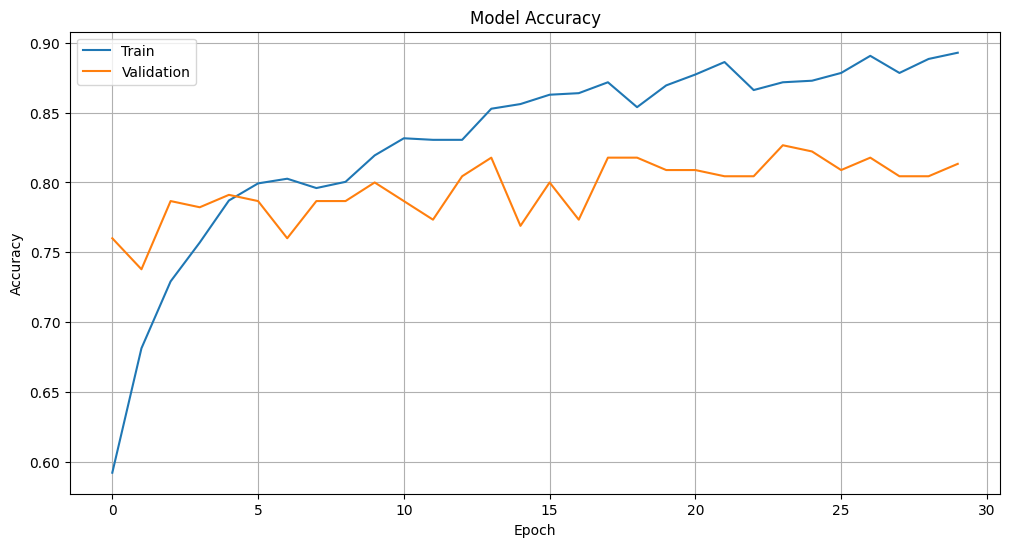

In [ ]:
# @title Plot Train and Validation Curves

plt.figure(figsize=(12, 6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_1.h5')

# save in TensorFlow SavedModel format
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_1')

In [ ]:
pip install pydot pydot-ng graphviz


In [ ]:
# @title Model-3

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Define input layers
smile_input = Input(shape=(2086,), name='smile_input')
poi_input = Input(shape=(1, 1024), name='poi_input')
e3_input = Input(shape=(1, 1024), name='e3_input')

# CNN for SMILES embeddings
smile_x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(tf.expand_dims(smile_input, axis=-1))
smile_x = MaxPooling1D(pool_size=2)(smile_x)
smile_x = Flatten()(smile_x)

# LSTM for POI embeddings
poi_x = LSTM(64)(tf.reshape(poi_input, (-1, 1024, 1)))

# LSTM for E3 embeddings
e3_x = LSTM(64)(tf.reshape(e3_input, (-1, 1024, 1)))

# Concatenate all features
concatenated = Concatenate()([smile_x, poi_x, e3_x])

# Fully connected layers
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[smile_input, poi_input, e3_input], outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Visualize the model architecture
plot_model(model, to_file='model_architecture_1.png', show_shapes=True, show_layer_names=True)

# Assuming X_smiles, X_poi, X_e3, and y are your datasets
# Fit the model
history = model.fit([X_smiles, X_poi, X_e3], y, epochs=30, batch_size=32, validation_split=0.2)

# Save the entire model
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_3.h5')

# Optionally, save in TensorFlow SavedModel format
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_3')



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 smile_input (InputLayer)    [(None, 2086)]               0         []                            
                                                                                                  
 tf.expand_dims_5 (TFOpLamb  (None, 2086, 1)              0         ['smile_input[0][0]']         
 da)                                                                                              
                                                                                                  
 conv1d_4 (Conv1D)           (None, 2086, 64)             256       ['tf.expand_dims_5[0][0]']    
                                                                                                  
 poi_input (InputLayer)      [(None, 1, 1024)]            0         []                      

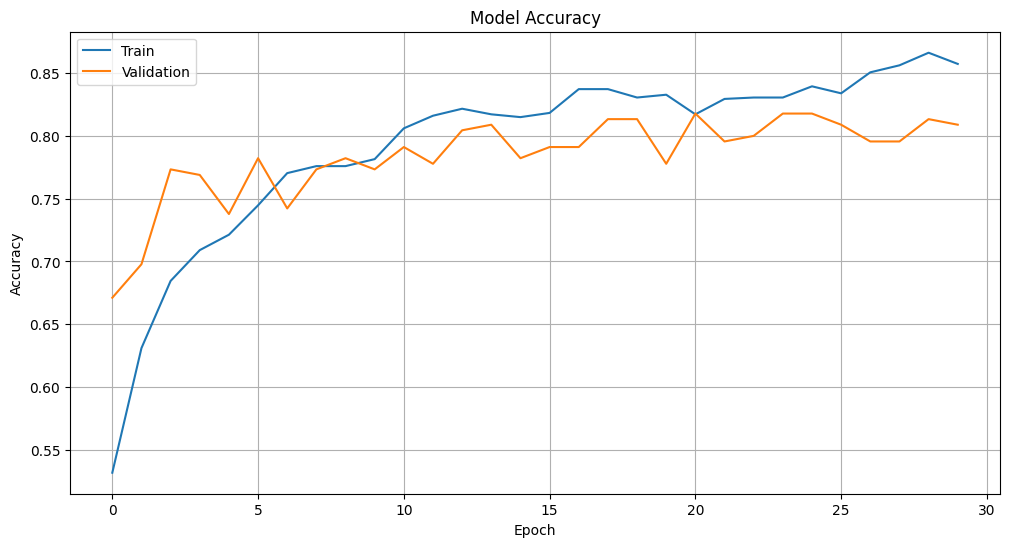

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# @title MODEL-2 **Don't Expand it, IT WILL CRASH THE CHROME. THIS ONE HAS BEEN AN UTTER DISAPPOINTMENT**

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Define input layers
smile_input = Input(shape=(2086,), name='smile_input')
poi_input = Input(shape=(1, 1024), name='poi_input')
e3_input = Input(shape=(1, 1024), name='e3_input')

# CNN for SMILES embeddings
smile_x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(tf.expand_dims(smile_input, axis=-1))
smile_x = MaxPooling1D(pool_size=2)(smile_x)
smile_x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(smile_x)
smile_x = MaxPooling1D(pool_size=2)(smile_x)
smile_x = Flatten()(smile_x)

# LSTM for POI embeddings
poi_x = LSTM(64)(tf.reshape(poi_input, (-1, 1024, 1)))

# LSTM for E3 embeddings
e3_x = LSTM(64)(tf.reshape(e3_input, (-1, 1024, 1)))

# Concatenate all features
concatenated = Concatenate()([smile_x, poi_x, e3_x])

# Add more CNN layers to the concatenated features
x = tf.expand_dims(concatenated, axis=-1)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[smile_input, poi_input, e3_input], outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Assuming X_smiles, X_poi, X_e3, and y are your datasets
# Fit the model
history = model.fit([X_smiles, X_poi, X_e3], y, epochs=30, batch_size=32, validation_split=0.2)

# Save the entire model
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/chatgpt2_my_model.h5')

# Optionally, save in TensorFlow SavedModel format
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/chatgpt2_my_model')


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 smile_input (InputLayer)    [(None, 2086)]               0         []                            
                                                                                                  
 tf.expand_dims_6 (TFOpLamb  (None, 2086, 1)              0         ['smile_input[0][0]']         
 da)                                                                                              
                                                                                                  
 conv1d_5 (Conv1D)           (None, 2086, 64)             256       ['tf.expand_dims_6[0][0]']    
                                                                                                  
 max_pooling1d_5 (MaxPoolin  (None, 1043, 64)             0         ['conv1d_5[0][0]']      

In [ ]:
# @title Model-not run

# Define model inputs
input_smiles = Input(shape=(2086,))
input_poi = Input(shape=(1, 1024))
input_e3 = Input(shape=(1, 1024))

# CNN part for SMILES embeddings
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_smiles)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=256, kernel_size=3, activation='relu')(x)

# Residual connection
residual = Conv1D(filters=256, kernel_size=1, activation='relu')(input_smiles)
residual = MaxPooling1D(pool_size=2)(residual)
x = Add()([x, residual])
x = Flatten()(x)

# LSTM part for POI and E3 embeddings
lstm_poi = LSTM(64, return_sequences=True)(input_poi)
lstm_e3 = LSTM(64, return_sequences=True)(input_e3)

# Concatenate CNN and LSTM outputs
x = Concatenate()([x, lstm_poi[:, -1, :], lstm_e3[:, -1, :]])

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Define and compile the model
model = Model(inputs=[input_smiles, input_poi, input_e3], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_train_smiles, X_train_poi, X_train_e3],
    y_train,
    validation_data=([X_val_smiles, X_val_poi, X_val_e3], y_val),
    epochs=30,
    batch_size=32
)

# Evaluate the model
loss, accuracy = model.evaluate([X_val_smiles, X_val_poi, X_val_e3], y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


In [ ]:
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_2.h5')

model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_2')


In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# @title MODEL-4
# Added Conv1D Layer: For both poi_input and e3_input
# Replaced LSTM with BiLSTM: Each LSTM layer is replaced with a single Bidirectional(LSTM(...)) layer
# Residual Connections: The residual connections are removed
# Added conv layer before BiLSTM
# Dropout is 0.5


from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Define input layers
smile_input = Input(shape=(2086,), name='smile_input')
poi_input = Input(shape=(None, 1024), name='poi_input')  # Changed 1 to None
e3_input = Input(shape=(None, 1024), name='e3_input')    # Changed 1 to None

# CNN for SMILES embeddings
smile_x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(tf.expand_dims(smile_input, axis=-1))
smile_x = Flatten()(smile_x)

# Conv1D and BiLSTM for POI embeddings
poi_conv = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(poi_input)
poi_bilstm = Bidirectional(LSTM(1024))(poi_conv)

# Conv1D and BiLSTM for E3 embeddings
e3_conv = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(e3_input)
e3_bilstm = Bidirectional(LSTM(1024))(e3_conv)

# Concatenate all features
concatenated = Concatenate()([smile_x, poi_bilstm, e3_bilstm])

# Fully connected layers
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[smile_input, poi_input, e3_input], outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Fit the model with early stopping
history = model.fit(
    [X_smiles, X_poi, X_e3],
    y,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Pass early stopping callback
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 smile_input (InputLayer)    [(None, 2086)]               0         []                            
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 2086, 1)              0         ['smile_input[0][0]']         
 )                                                                                                
                                                                                                  
 poi_input (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 e3_input (InputLayer)       [(None, None, 1024)]         0         []                        

In [ ]:
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_4.h5')

model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_4')

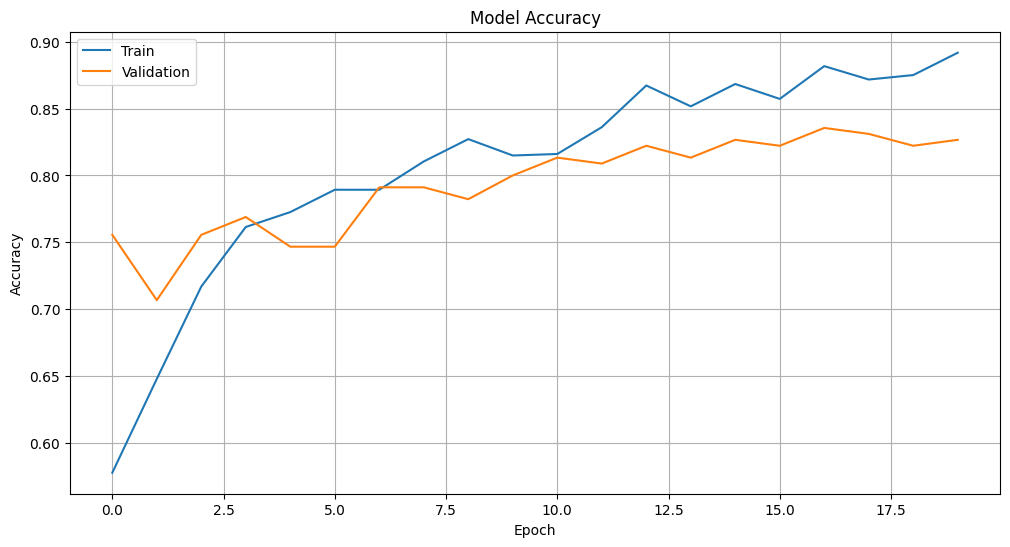

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

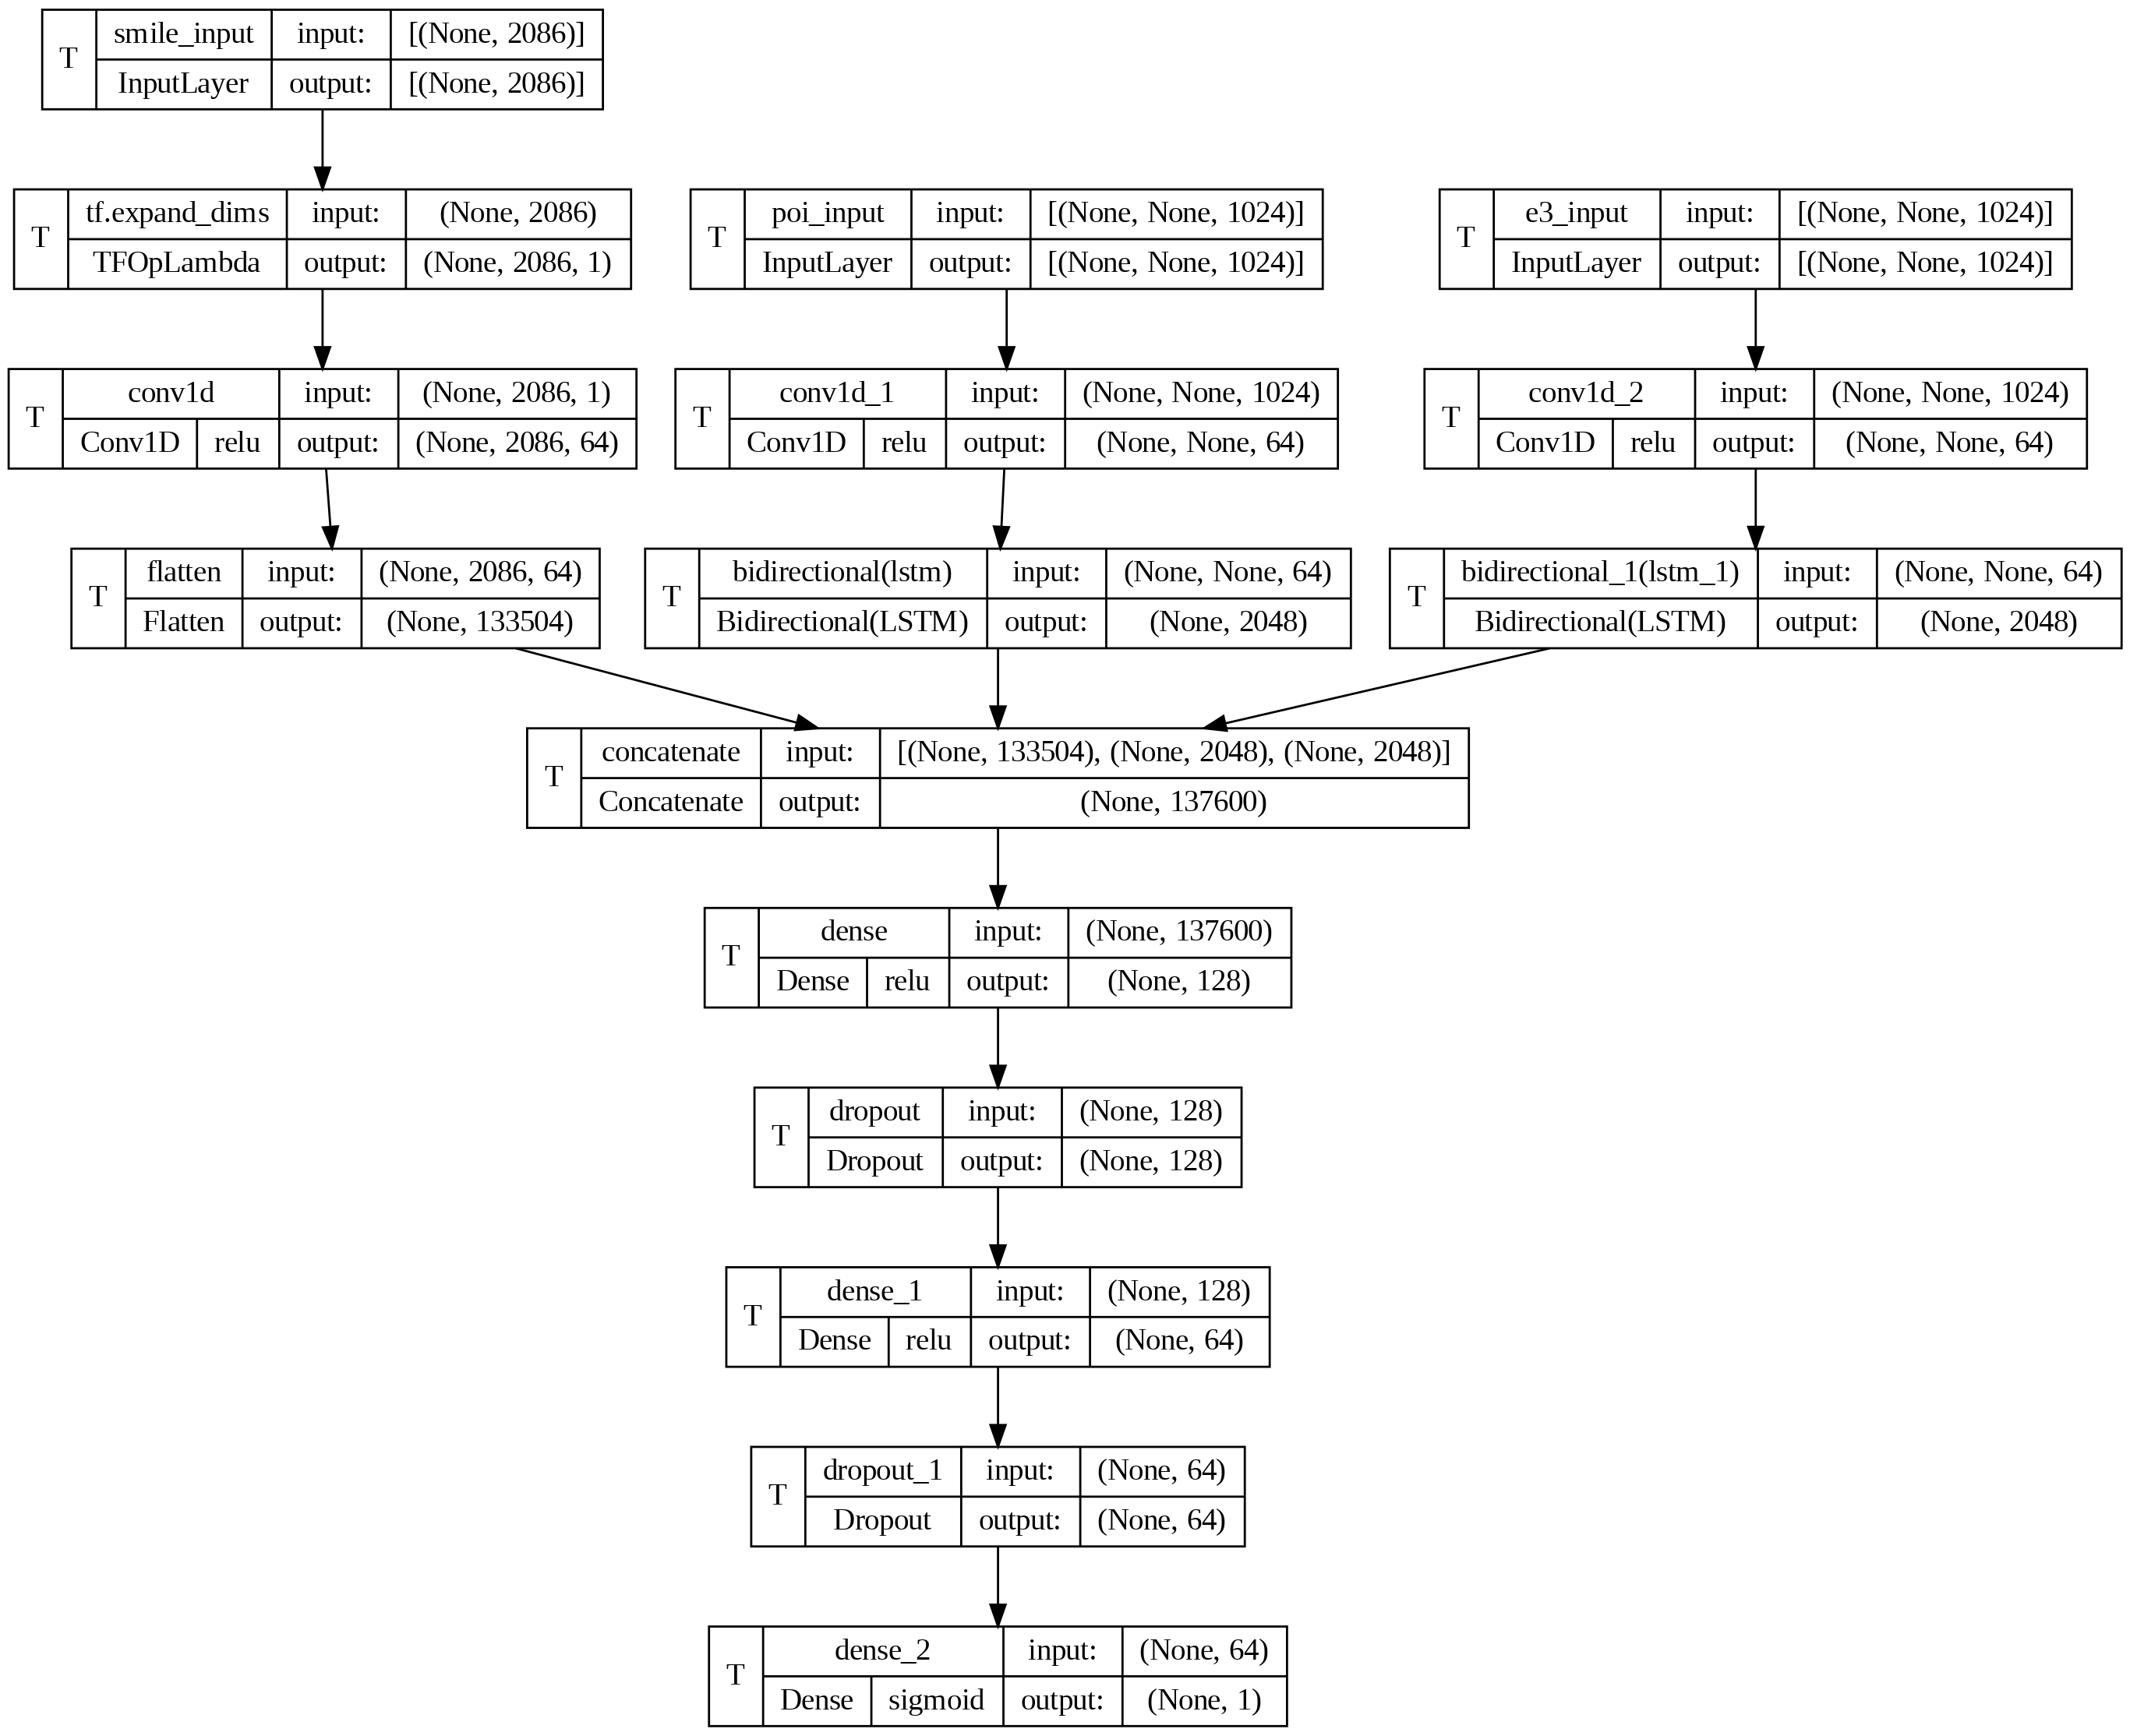

In [ ]:
# @title model visualization
# model = keras.models.load_model(model)

keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,

)

6/6 [==============================] - 1s 7ms/step
Accuracy: 0.8199
Precision: 0.8333
Recall: 0.8025
F1 Score: 0.8176
ROC AUC: 0.9029
Log Loss: 0.4120


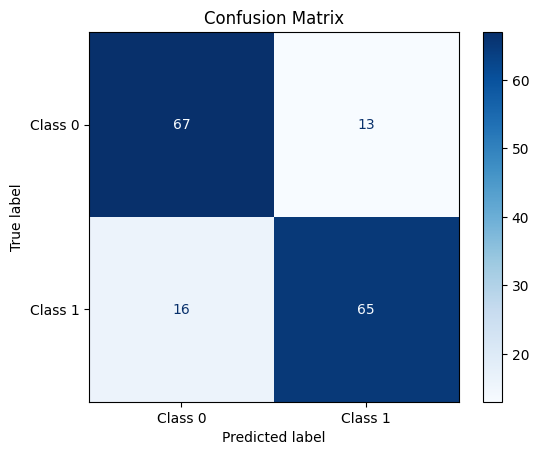

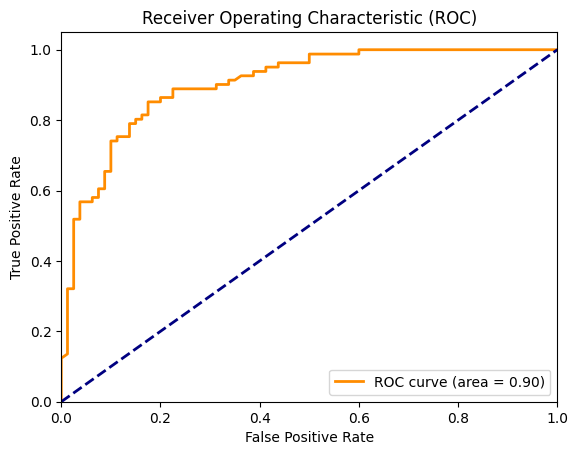

In [ ]:
model_path = '/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_4.h5'
evaluate_model(model_path, scaled_new_data, test_poi, test_e3, y_test)

In [ ]:
# @title Model-5

# no conv layer only BiLSTM
# No residual layers

from tensorflow.keras.layers import Input, Bidirectional, LSTM, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Define input layers
smile_input = Input(shape=(2086,), name='smile_input')
poi_input = Input(shape=(1, 1024), name='poi_input')
e3_input = Input(shape=(1, 1024), name='e3_input')

# CNN for SMILES embeddings
smile_x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(tf.expand_dims(smile_input, axis=-1))
smile_x = Flatten()(smile_x)

# BiLSTM for POI embeddings
poi_bilstm = Bidirectional(LSTM(1024, return_sequences=True))(poi_input)
poi_x = Flatten()(poi_bilstm)

# BiLSTM for E3 embeddings
e3_bilstm = Bidirectional(LSTM(1024, return_sequences=True))(e3_input)
e3_x = Flatten()(e3_bilstm)

# Concatenate all features
concatenated = Concatenate()([smile_x, poi_x, e3_x])

# Fully connected layers
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[smile_input, poi_input, e3_input], outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fit the model with early stopping
history = model.fit(
    [X_train_smiles, X_train_poi, X_train_e3],
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_smiles, X_val_poi, X_val_e3], y_val),
    callbacks=[early_stopping]
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 smile_input (InputLayer)    [(None, 2086)]               0         []                            
                                                                                                  
 tf.expand_dims_6 (TFOpLamb  (None, 2086, 1)              0         ['smile_input[0][0]']         
 da)                                                                                              
                                                                                                  
 poi_input (InputLayer)      [(None, 1, 1024)]            0         []                            
                                                                                                  
 e3_input (InputLayer)       [(None, 1, 1024)]            0         []                      

In [ ]:
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_5.h5')

model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_5')

6/6 [==============================] - 2s 8ms/step
Accuracy: 0.8075
Precision: 0.8378
Recall: 0.7654
F1 Score: 0.8000
ROC AUC: 0.8899
Log Loss: 0.4352


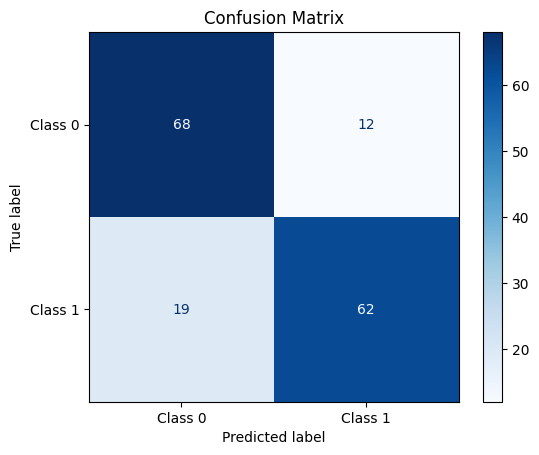

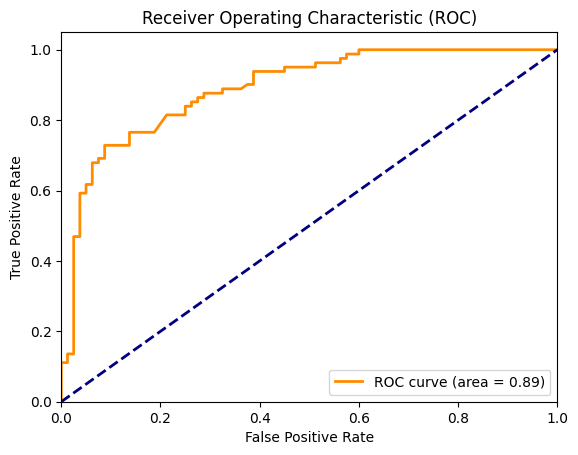

In [ ]:
model_path = '/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_5.h5'
evaluate_model(model_path, scaled_new_data, test_poi, test_e3, y_test)

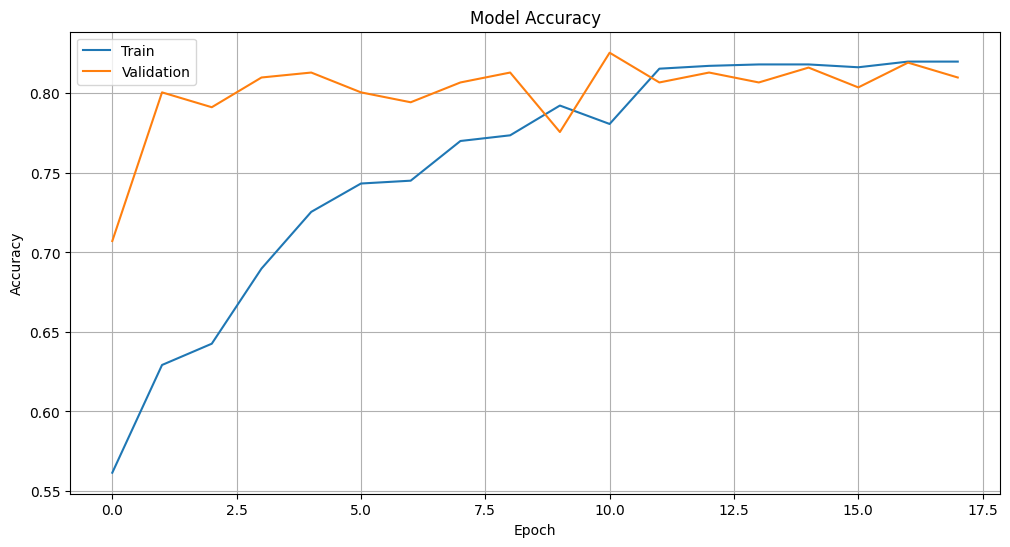

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# @title Model-6

# added conv layer after BiLSTM

from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Define input layers
smile_input = Input(shape=(2086,), name='smile_input')
poi_input = Input(shape=(1, 1024), name='poi_input')
e3_input = Input(shape=(1, 1024), name='e3_input')

# CNN for SMILES embeddings
smile_x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(tf.expand_dims(smile_input, axis=-1))
smile_x = Flatten()(smile_x)

# BiLSTM and Conv1D for POI embeddings
poi_bilstm = Bidirectional(LSTM(1024, return_sequences=True))(poi_input)
poi_conv_after_bilstm = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(poi_bilstm)
poi_x = Flatten()(poi_conv_after_bilstm)

# BiLSTM and Conv1D for E3 embeddings
e3_bilstm = Bidirectional(LSTM(1024, return_sequences=True))(e3_input)
e3_conv_after_bilstm = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(e3_bilstm)
e3_x = Flatten()(e3_conv_after_bilstm)

# Concatenate all features
concatenated = Concatenate()([smile_x, poi_x, e3_x])

# Fully connected layers
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[smile_input, poi_input, e3_input], outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Fit the model with early stopping
history = model.fit(
    [X_train_smiles, X_train_poi, X_train_e3],
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_smiles, X_val_poi, X_val_e3], y_val),
    callbacks=[early_stopping]
)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 smile_input (InputLayer)    [(None, 2086)]               0         []                            
                                                                                                  
 poi_input (InputLayer)      [(None, 1, 1024)]            0         []                            
                                                                                                  
 e3_input (InputLayer)       [(None, 1, 1024)]            0         []                            
                                                                                                  
 tf.expand_dims_9 (TFOpLamb  (None, 2086, 1)              0         ['smile_input[0][0]']         
 da)                                                                                        

In [ ]:
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_6.h5')

model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_6')

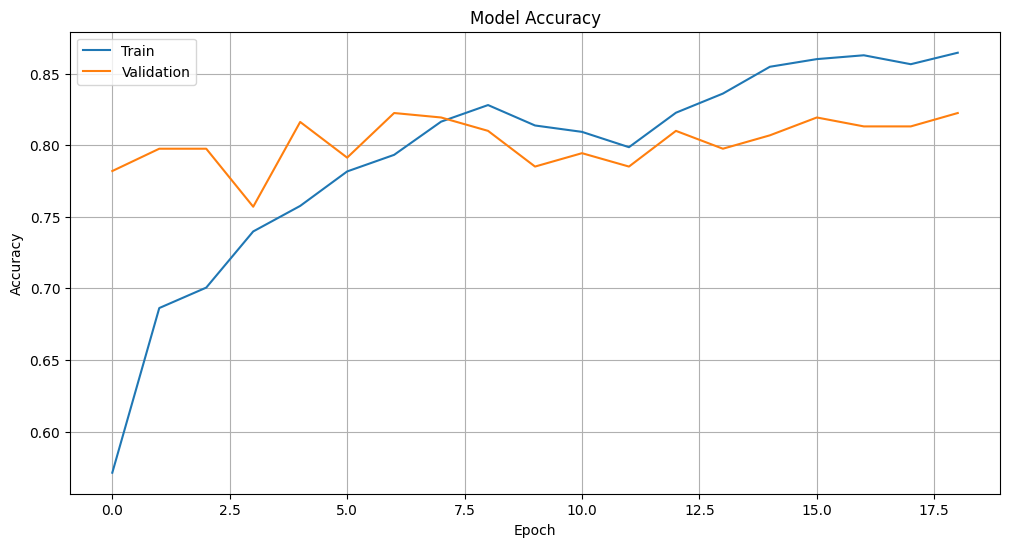

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

6/6 [==============================] - 4s 21ms/step
Accuracy: 0.8075
Precision: 0.8049
Recall: 0.8148
F1 Score: 0.8098
ROC AUC: 0.8969
Log Loss: 0.4086


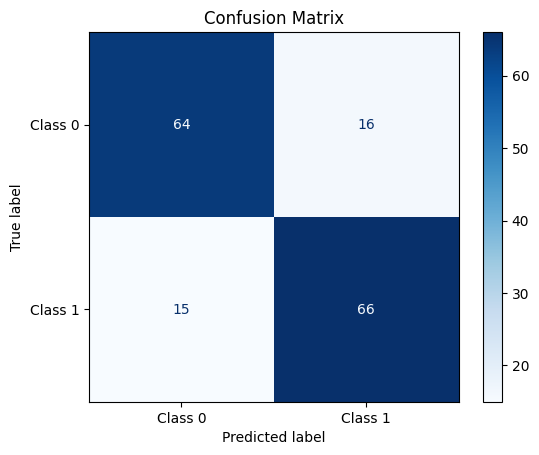

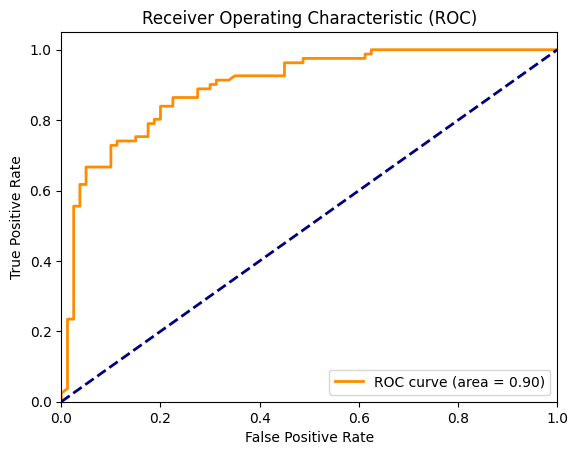

In [ ]:
model_path = '/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_6.h5'
evaluate_model(model_path, scaled_new_data, test_poi, test_e3, y_test)

In [ ]:
# @title Model-7

# Added Conv layer before and after BiLSTM
# Define input layers
smile_input = Input(shape=(2086,), name='smile_input')
poi_input = Input(shape=(1, 1024), name='poi_input')  # Removed Fixed shape
e3_input = Input(shape=(1, 1024), name='e3_input')    # Removed Fixed shape

# CNN for SMILES embeddings
smile_x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(tf.expand_dims(smile_input, axis=-1))
smile_x = Flatten()(smile_x)

# Conv1D and BiLSTM for POI embeddings
poi_conv_before_bilstm = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(poi_input)
poi_bilstm = Bidirectional(LSTM(1024, return_sequences=True))(poi_conv_before_bilstm)
poi_conv_after_bilstm = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(poi_bilstm)
poi_x = Flatten()(poi_conv_after_bilstm)

# Residual connection for POI embeddings
poi_residual = Add()([Flatten()(poi_conv_before_bilstm), poi_x])

# Conv1D and BiLSTM for E3 embeddings
e3_conv_before_bilstm = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(e3_input)
e3_bilstm = Bidirectional(LSTM(1024, return_sequences=True))(e3_conv_before_bilstm)
e3_conv_after_bilstm = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(e3_bilstm)
e3_x = Flatten()(e3_conv_after_bilstm)

# Residual connection for E3 embeddings
e3_residual = Add()([Flatten()(e3_conv_before_bilstm), e3_x])

# Concatenate all features
concatenated = Concatenate()([smile_x, poi_residual, e3_residual])

# Fully connected layers
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[smile_input, poi_input, e3_input], outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fit the model with early stopping
history = model.fit(
    [X_train_smiles, X_train_poi, X_train_e3],
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_smiles, X_val_poi, X_val_e3], y_val),
    callbacks=[early_stopping]
)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 poi_input (InputLayer)      [(None, 1, 1024)]            0         []                            
                                                                                                  
 e3_input (InputLayer)       [(None, 1, 1024)]            0         []                            
                                                                                                  
 conv1d_43 (Conv1D)          (None, 1, 64)                196672    ['poi_input[0][0]']           
                                                                                                  
 conv1d_45 (Conv1D)          (None, 1, 64)                196672    ['e3_input[0][0]']            
                                                                                            

In [ ]:
model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_7.h5')

model.save('/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_7')

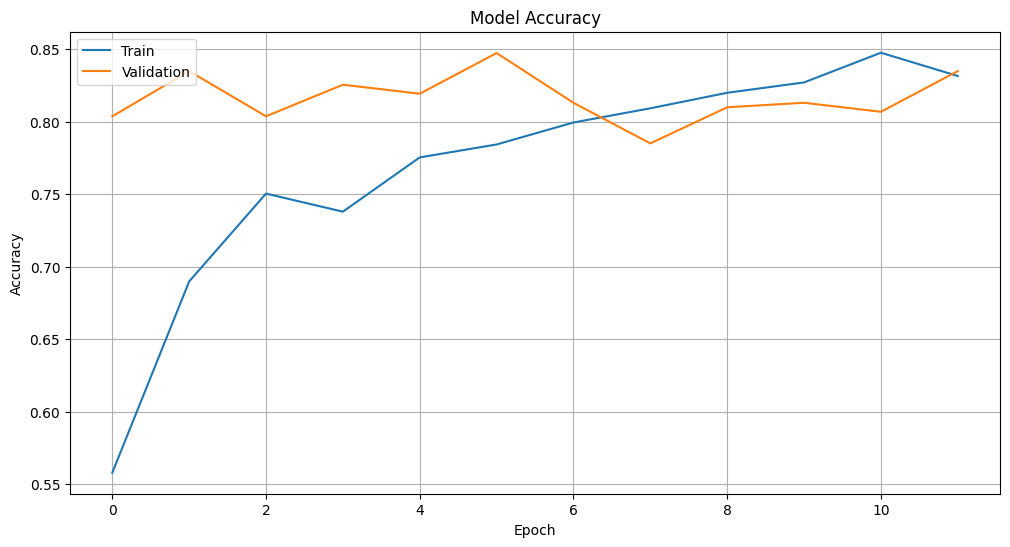

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

6/6 [==============================] - 2s 11ms/step
Accuracy: 0.8137
Precision: 0.8312
Recall: 0.7901
F1 Score: 0.8101
ROC AUC: 0.9025
Log Loss: 0.3955


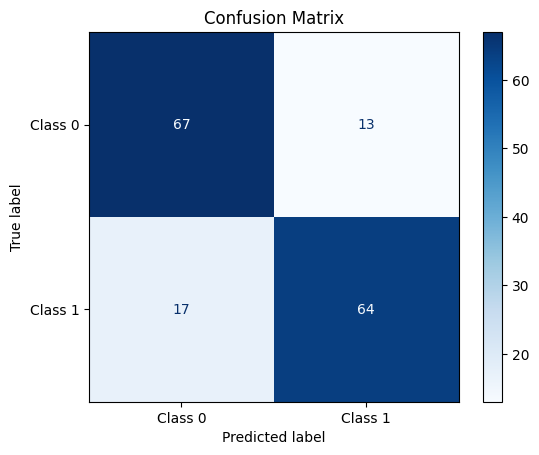

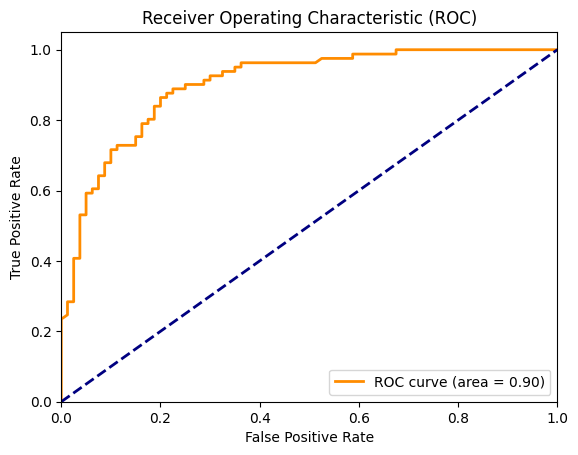

In [ ]:
model_path = '/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_7.h5'
evaluate_model(model_path, scaled_new_data, test_poi, test_e3, y_test)

# **😎😎MODEL EVATUATION🤩🤩**

In [ ]:
model_path = "/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_1.h5"

In [ ]:
!pip install visualkeras -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 8.4 MB/s eta 0:00:00


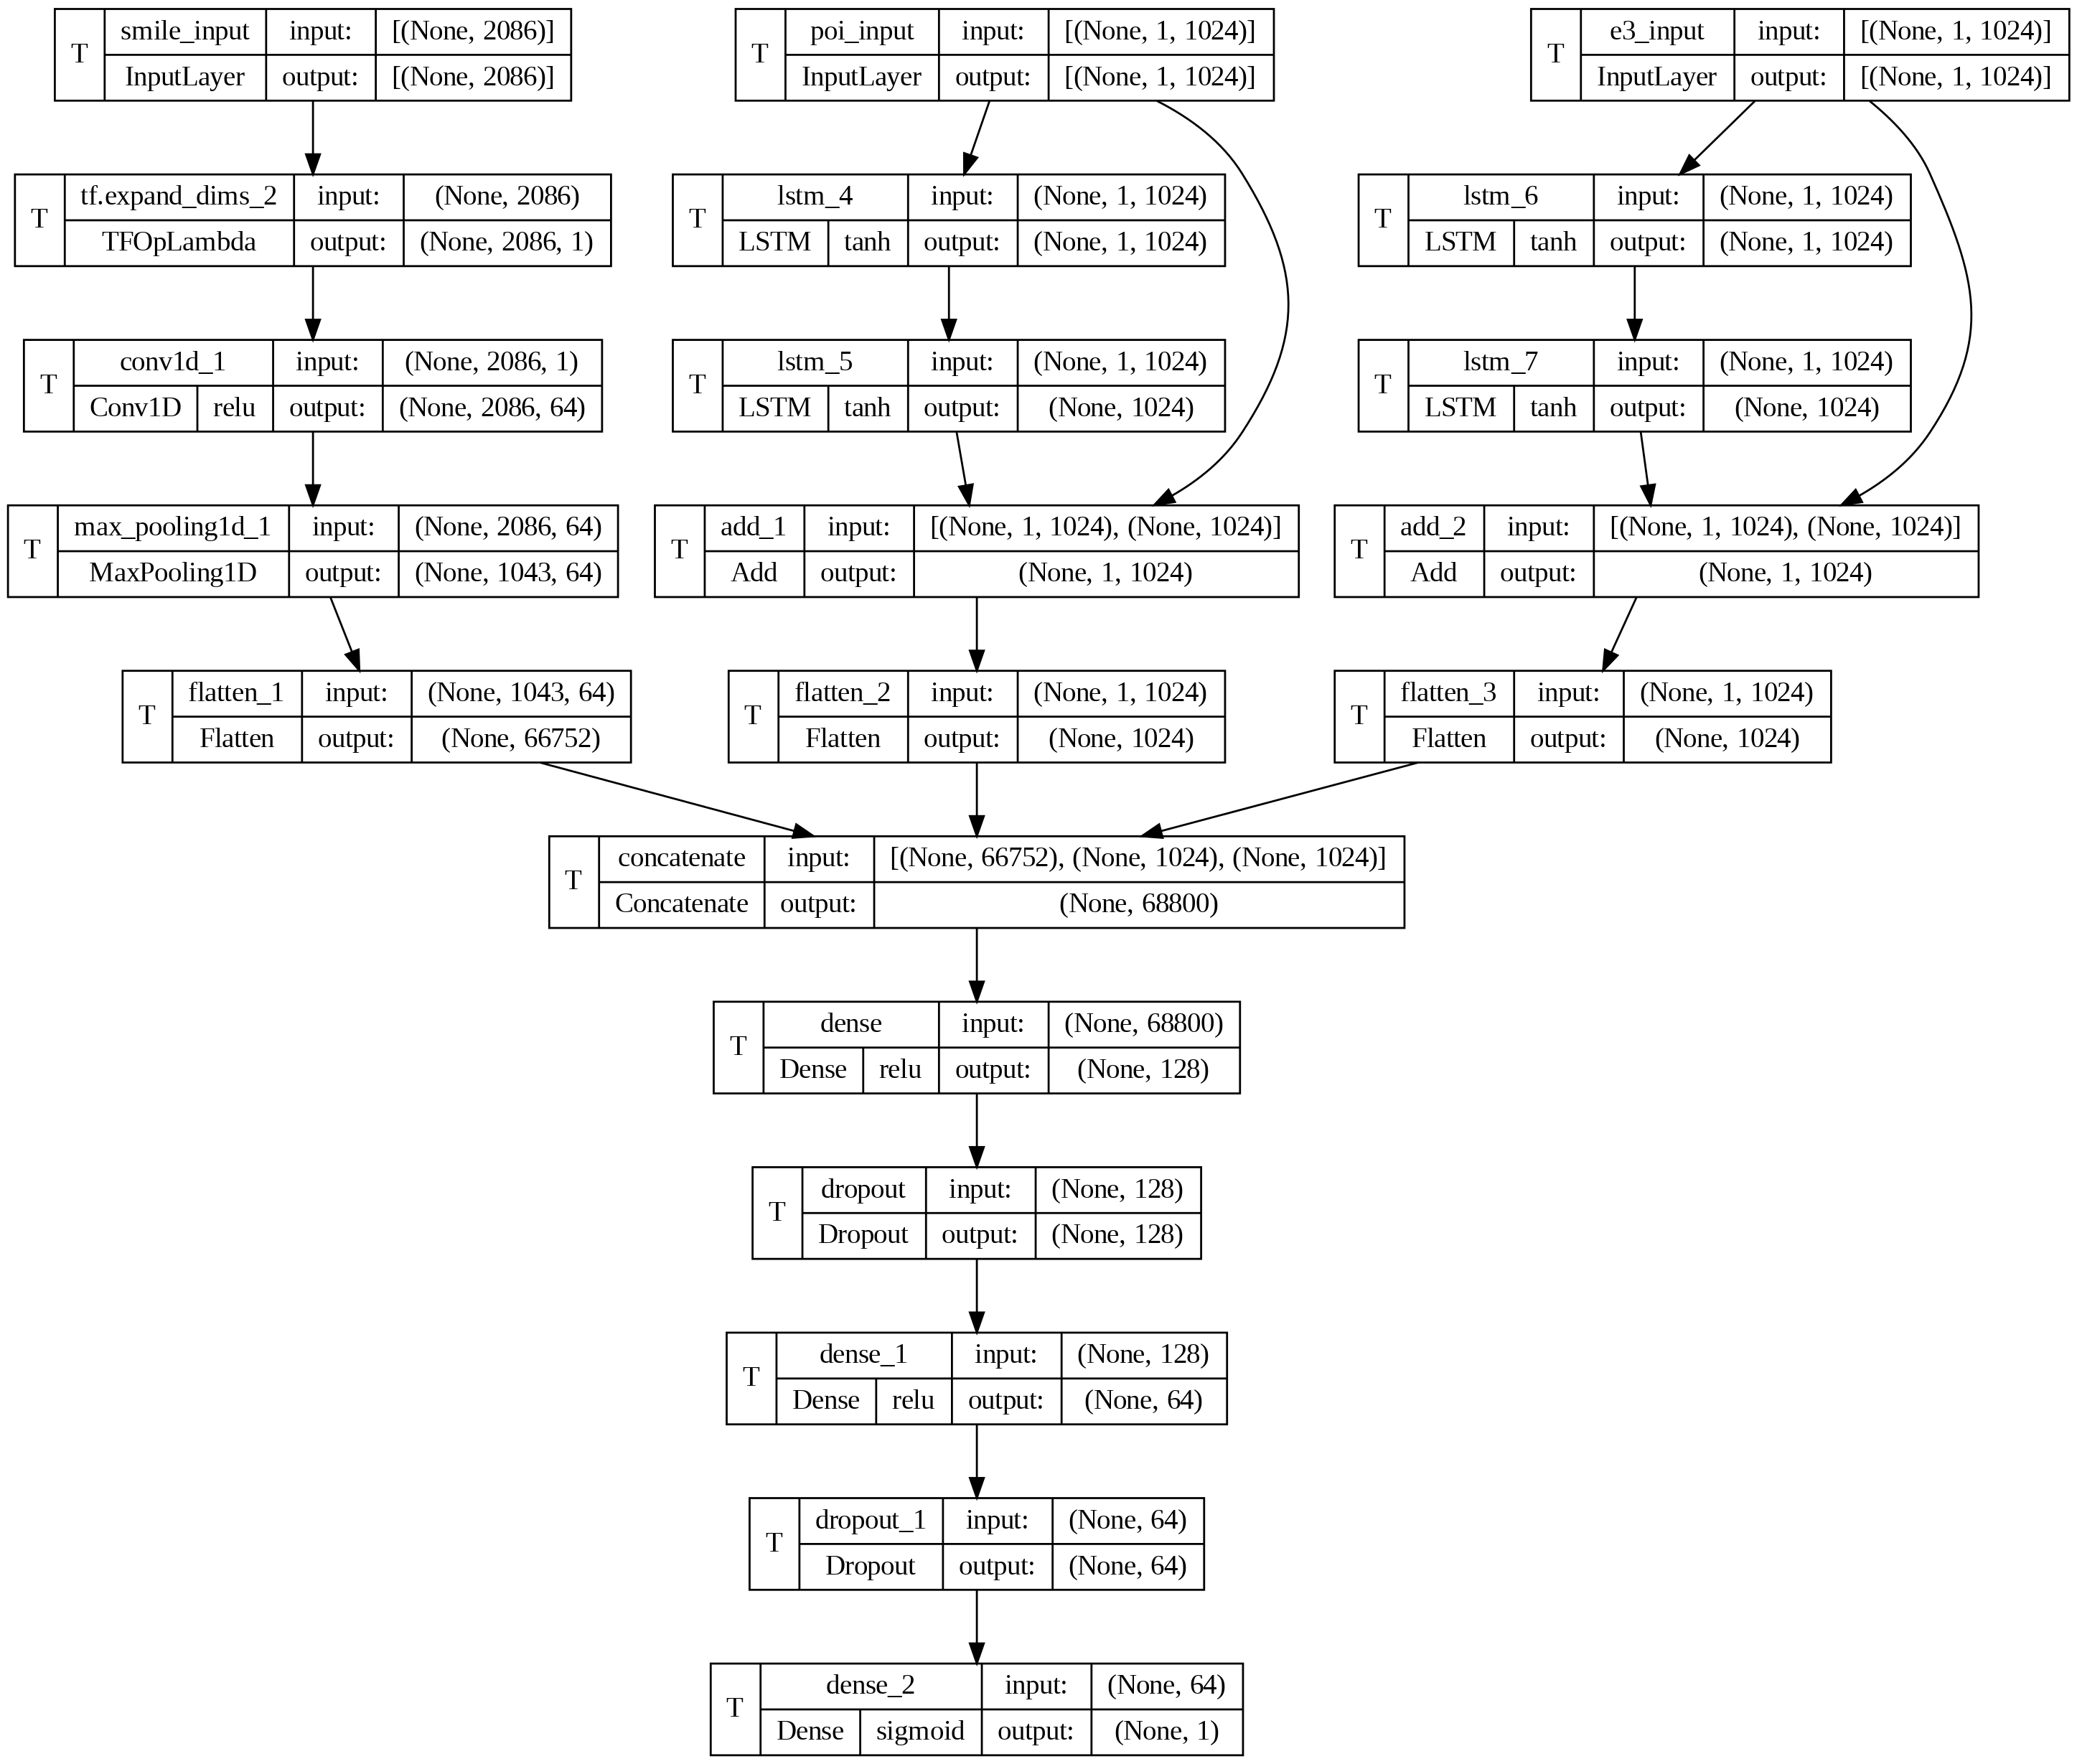

In [ ]:
model = keras.models.load_model(model_path)

keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,

)

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)

In [ ]:
def evaluate_model(model_path, X_test_smiles, X_test_poi, X_test_e3, y_test):
    # Load the saved model
    model = tf.keras.models.load_model(model_path)

    # Predict on test data
    predictions = model.predict([X_test_smiles, X_test_poi, X_test_e3])
    y_prob = predictions.flatten()
    y_pred = (y_prob > 0.5).astype(int)

    # Calc evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    logloss = log_loss(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Log Loss: {logloss:.4f}")

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()




6/6 [==============================] - 2s 72ms/step
Accuracy: 0.8385
Precision: 0.8481
Recall: 0.8272
F1 Score: 0.8375
ROC AUC: 0.8829
Log Loss: 0.6487


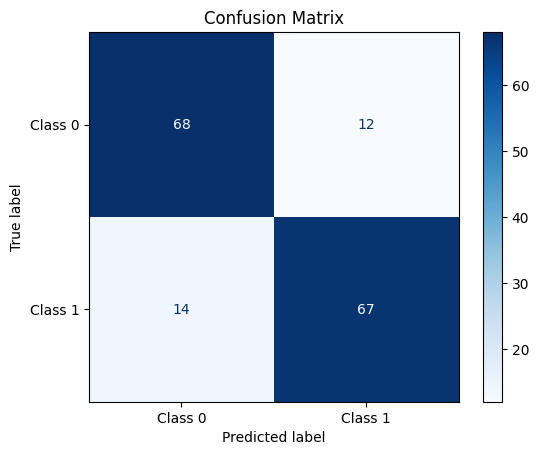

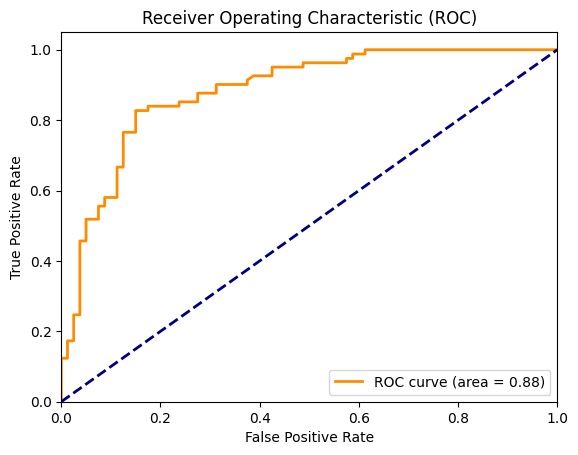

In [ ]:
evaluate_model(model_path, scaled_new_data, test_poi, test_e3, y_test)

In [ ]:
model_path = "/content/drive/MyDrive/Protacs_new_dataset/Models/strat_model_2.h5"

6/6 [==============================] - 2s 134ms/step
Accuracy: 0.8137
Precision: 0.8000
Recall: 0.8395
F1 Score: 0.8193
ROC AUC: 0.8837
Log Loss: 0.6591


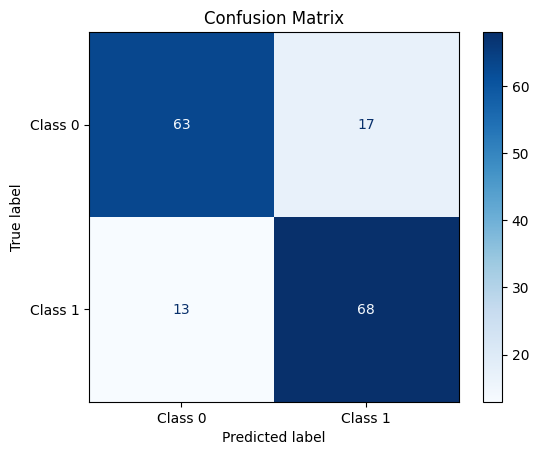

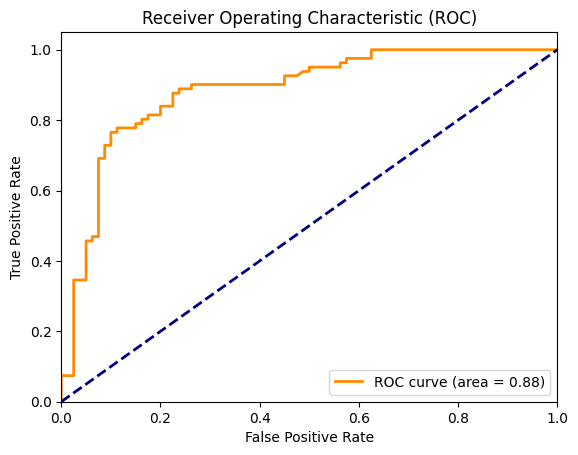

In [ ]:
evaluate_model(model_path, scaled_new_data, test_poi, test_e3, y_test)